#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

#### Test for CUDA

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Data loader, train and test sets

In [5]:
batch_size = 200

In [6]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Classes in the MNIST dataset
classes = [str(x) for x in range(10)]
num_classes = len(classes)
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
# Print some information about the datasets
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of classes:", num_classes)

Number of training examples: 60000
Number of test examples: 10000
Number of classes: 10


#### Model and other hyper-params

In [9]:
# Hyperparameters
input_size = 28  # MNIST image size (28x28)
num_steps = 28
hidden_size = 128
num_layers = 1
num_epochs = 50
learning_rate = 0.001

In [10]:
N = hidden_size ## num. of neurons in RNN

In [11]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [12]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [13]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
#             fr_mask = ht.clone()>0
#             htt = fr_mask*ht.clone() ## mask firing rate
            h0 = ht ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = self.fc(ops[:, ii, :].clone())
            
        out = pred[:, -1, :].clone()  #Take the output from the last time step
        
        return out, ht

#### Connectivity and sign constraints

In [14]:
nRuns = 5

In [15]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [16]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [17]:
# Initialize the model
model = {}
weights_init = {}

In [18]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, num_classes, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

In [19]:
pp = 1.0
conn_mask = {}
sign_mask = {}
full_mask = {}

In [20]:
for cntr in range(nRuns):
    conn_mask[cntr] = np.random.choice([0, 1], size=(N,N), p=[1-pp, pp])
    sign_mask[cntr] = np.sign(weights_init[cntr])
    sign_mask[cntr][sign_mask[cntr] == 0] = 1
    full_mask[cntr] = torch.from_numpy(sign_mask[cntr]*conn_mask[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Rectified Backprop')

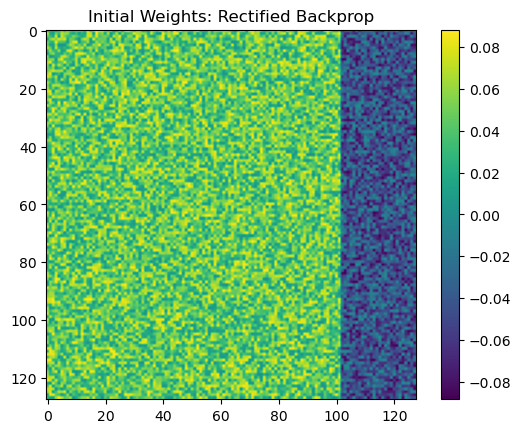

In [43]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Rectified Backprop')

In [47]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_init_rectified.npz', weights_init, pickle=True)

Text(0, 0.5, 'Counts')

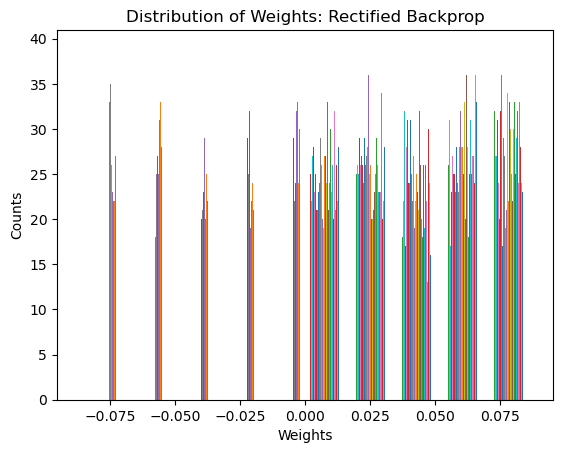

In [42]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Rectified Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [24]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))
accuracies = np.zeros((nRuns, num_epochs))

In [25]:
for run in tqdm(range(nRuns)):

    # Training the model
    for epoch in range(num_epochs):
        for ii, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, firing_rates = model[run](images)
            loss = criterion(outputs, labels)
            train_losses[run,epoch] = loss

            # Backward and optimize
            optimizer[run].zero_grad()
            loss.backward()
            optimizer[run].step()

            ## Rectify weights
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            w[w < 0] = 0
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(w).float().to(device)

            ## Apply mask
            model[run].rnn.weight_hh_l0.data = full_mask[run]*model[run].rnn.weight_hh_l0.data

            if (ii+1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Test the model
        with torch.no_grad():
            correct = 0
            total = 0
            for images_test, labels_test in test_loader:
                images_test = images_test.reshape(-1, 28, 28).to(device)
                labels_test = labels_test.to(device)
                outputs_test, firing_rates_test = model[run](images_test)
                loss_test = criterion(outputs_test, labels_test)
                test_losses[run,epoch] = loss_test
                ## accuracy
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            print(f'Accuracy of the network on the test images: {100 * correct / total}%')
            accuracies[run,epoch] = 100 * correct / total

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/50], Loss: 2.3017
Accuracy of the network on the test images: 13.23%
Epoch [2/50], Loss: 1.7274
Accuracy of the network on the test images: 37.62%
Epoch [3/50], Loss: 1.6165
Accuracy of the network on the test images: 40.72%
Epoch [4/50], Loss: 1.6224
Accuracy of the network on the test images: 41.46%
Epoch [5/50], Loss: 1.5521
Accuracy of the network on the test images: 42.05%
Epoch [6/50], Loss: 1.4162
Accuracy of the network on the test images: 47.77%
Epoch [7/50], Loss: 1.4182
Accuracy of the network on the test images: 52.01%
Epoch [8/50], Loss: 1.3149
Accuracy of the network on the test images: 48.8%
Epoch [9/50], Loss: 1.2839
Accuracy of the network on the test images: 40.24%
Epoch [10/50], Loss: 1.4662
Accuracy of the network on the test images: 42.19%
Epoch [11/50], Loss: 1.5015
Accuracy of the network on the test images: 42.51%
Epoch [12/50], Loss: 1.4122
Accuracy of the network on the test images: 42.99%
Epoch [13/50], Loss: 1.4887
Accuracy of the network on the tes

 20%|██        | 1/5 [33:01<2:12:04, 1981.01s/it]

Accuracy of the network on the test images: 51.97%
Epoch [1/50], Loss: 2.3146
Accuracy of the network on the test images: 10.47%
Epoch [2/50], Loss: 1.7800
Accuracy of the network on the test images: 35.63%
Epoch [3/50], Loss: 1.4977
Accuracy of the network on the test images: 44.11%
Epoch [4/50], Loss: 1.3499
Accuracy of the network on the test images: 45.95%
Epoch [5/50], Loss: 2.4269
Accuracy of the network on the test images: 46.98%
Epoch [6/50], Loss: 1.3037
Accuracy of the network on the test images: 48.12%
Epoch [7/50], Loss: 1.2007
Accuracy of the network on the test images: 48.62%
Epoch [8/50], Loss: 1.3721
Accuracy of the network on the test images: 50.75%
Epoch [9/50], Loss: 1.1917
Accuracy of the network on the test images: 50.61%
Epoch [10/50], Loss: 1.2928
Accuracy of the network on the test images: 51.25%
Epoch [11/50], Loss: 1.1878
Accuracy of the network on the test images: 49.5%
Epoch [12/50], Loss: 1.1751
Accuracy of the network on the test images: 55.69%
Epoch [13/5

 40%|████      | 2/5 [1:05:42<1:38:28, 1969.61s/it]

Accuracy of the network on the test images: 85.87%
Epoch [1/50], Loss: 2.3216
Accuracy of the network on the test images: 9.82%
Epoch [2/50], Loss: 1.9060
Accuracy of the network on the test images: 34.29%
Epoch [3/50], Loss: 1.4239
Accuracy of the network on the test images: 45.93%
Epoch [4/50], Loss: 1.3635
Accuracy of the network on the test images: 46.94%
Epoch [5/50], Loss: 1.3431
Accuracy of the network on the test images: 49.27%
Epoch [6/50], Loss: 1.2346
Accuracy of the network on the test images: 50.17%
Epoch [7/50], Loss: 1.2651
Accuracy of the network on the test images: 51.15%
Epoch [8/50], Loss: 1.2838
Accuracy of the network on the test images: 52.57%
Epoch [9/50], Loss: 1.1638
Accuracy of the network on the test images: 53.24%
Epoch [10/50], Loss: 1.1575
Accuracy of the network on the test images: 55.71%
Epoch [11/50], Loss: 0.9928
Accuracy of the network on the test images: 61.18%
Epoch [12/50], Loss: 0.8575
Accuracy of the network on the test images: 64.71%
Epoch [13/5

 60%|██████    | 3/5 [1:38:17<1:05:26, 1963.04s/it]

Accuracy of the network on the test images: 79.5%
Epoch [1/50], Loss: 2.3184
Accuracy of the network on the test images: 10.28%
Epoch [2/50], Loss: 2.5195
Accuracy of the network on the test images: 32.55%
Epoch [3/50], Loss: 1.7075
Accuracy of the network on the test images: 30.94%
Epoch [4/50], Loss: 1.3723
Accuracy of the network on the test images: 45.1%
Epoch [5/50], Loss: 1.3188
Accuracy of the network on the test images: 46.74%
Epoch [6/50], Loss: 1.3729
Accuracy of the network on the test images: 48.75%
Epoch [7/50], Loss: 1.3661
Accuracy of the network on the test images: 48.38%
Epoch [8/50], Loss: 1.1927
Accuracy of the network on the test images: 50.26%
Epoch [9/50], Loss: 1.4465
Accuracy of the network on the test images: 51.98%
Epoch [10/50], Loss: 1.1070
Accuracy of the network on the test images: 53.77%
Epoch [11/50], Loss: 1.1814
Accuracy of the network on the test images: 56.53%
Epoch [12/50], Loss: 1.2056
Accuracy of the network on the test images: 60.48%
Epoch [13/50

 80%|████████  | 4/5 [2:10:50<32:38, 1958.83s/it]  

Accuracy of the network on the test images: 86.69%
Epoch [1/50], Loss: 2.2901
Accuracy of the network on the test images: 9.58%
Epoch [2/50], Loss: 1.6267
Accuracy of the network on the test images: 43.01%
Epoch [3/50], Loss: 1.3554
Accuracy of the network on the test images: 45.74%
Epoch [4/50], Loss: 1.3553
Accuracy of the network on the test images: 48.71%
Epoch [5/50], Loss: 1.2886
Accuracy of the network on the test images: 49.05%
Epoch [6/50], Loss: 1.1819
Accuracy of the network on the test images: 49.48%
Epoch [7/50], Loss: 1.2415
Accuracy of the network on the test images: 49.86%
Epoch [8/50], Loss: 1.2854
Accuracy of the network on the test images: 50.93%
Epoch [9/50], Loss: 1.3063
Accuracy of the network on the test images: 50.96%
Epoch [10/50], Loss: 1.1448
Accuracy of the network on the test images: 54.86%
Epoch [11/50], Loss: 1.0782
Accuracy of the network on the test images: 55.81%
Epoch [12/50], Loss: 1.0993
Accuracy of the network on the test images: 57.34%
Epoch [13/5

100%|██████████| 5/5 [2:43:26<00:00, 1961.30s/it]

Accuracy of the network on the test images: 87.2%


In [26]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [46]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_final_rectified.npz', weights_final, pickle=True)

Text(0.5, 1.0, 'Final Weights')

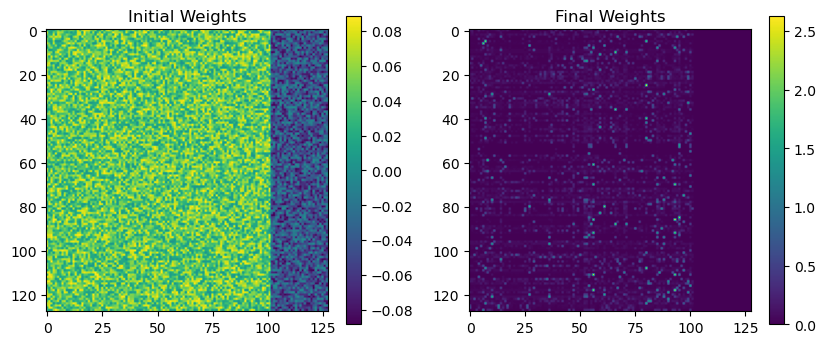

In [27]:
kk = 0

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

plt.subplot(122)
plt.imshow(weights_final[kk])
plt.colorbar()
plt.title('Final Weights')

In [40]:
# neg_wts = weights_final[kk]*(weights_final[kk]<0)
# plt.hist(neg_wts)

Text(0, 0.5, 'Counts')

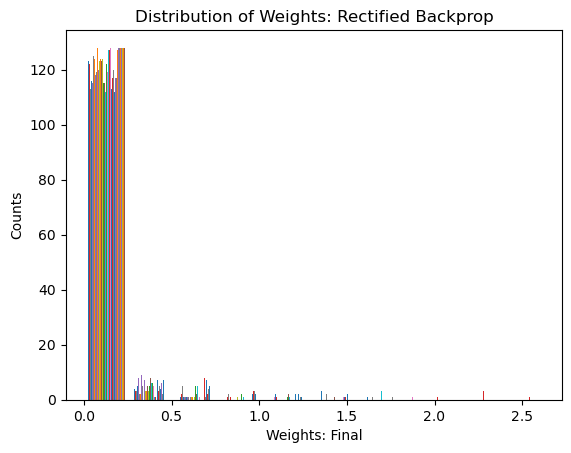

In [33]:
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Rectified Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [28]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

mean_accs = np.mean(accuracies, axis=0)
variance_accs = np.var(accuracies, axis=0)

In [45]:
## Save train, test losses + accuracies
np.save('seq_mnist_train_losses_rectified_backprop',train_losses)
np.save('seq_mnist_test_losses_rectified_backprop',test_losses)
np.save('seq_mnist_accuracies_rectified_backprop',accuracies)

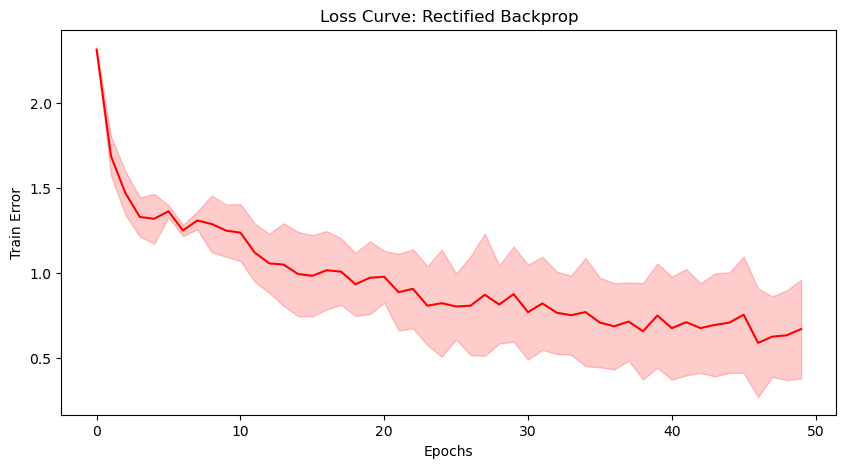

In [32]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_train_losses, color='r')
plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
                 color='r', alpha=0.2)

# sns.lineplot(x=x, y=mean_test_losses, color='r')
# plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
#                  color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.title('Loss Curve: Rectified Backprop')

# Show plot
plt.show()

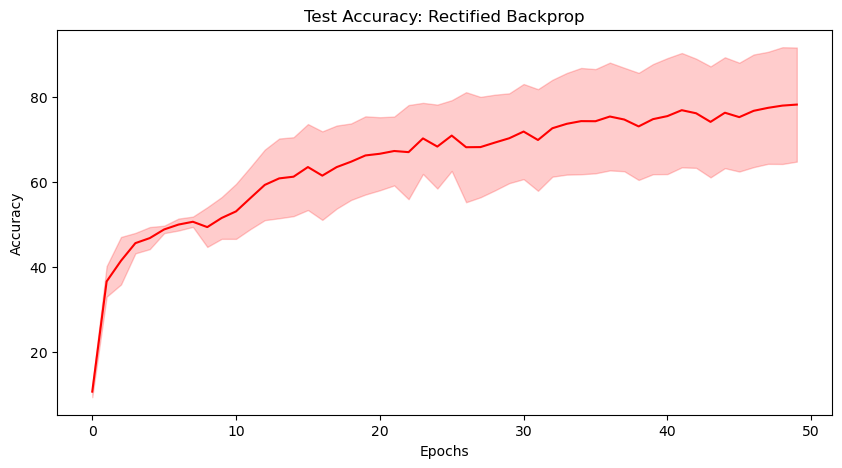

In [31]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_accs, color='r')
plt.fill_between(x, mean_accs - np.sqrt(variance_accs), mean_accs + np.sqrt(variance_accs),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy: Rectified Backprop')

# Show plot
plt.show()